# The Task

- To find who’s the top 3 Influencers in the entire discussion
- You can decide what an influencer means
- Find at least one interesting insight you can derive from the dataset
- State all your assumptions clearly.

# The Dataset

The Reddit Dataset contains discussion and non-discussion based threads from Reddit which we collected in May 2018. Nodes are Reddit users who participate in a discussion and links are replies between them.

## Properties
- Number of graphs: 203,088
- Directed: No.
- Node features: No.
- Edge features: No.
- Graph labels: Yes. Binary-labeled.
- Temporal: No.

## Assumptions:
- Each edge is counted only *once.* This is implemented using NetworkX's `Graph()` method (to count every edge more than once, `Multigraph()` can be used, however, there are various centrality measures that cannot be implemented on it.)
- The network is symmetric - if A and B are linked by an edge, A is related to B and B is related to A.

# Imports

## Loading libraries

The analysis is done using NetworkX, a Python language software package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks. It is used to study large complex networks represented in form of graphs with nodes and edges. Using networkx we can load and store complex networks. 
To work with the datasets provided, the JSON and Pandas libraries are also imported. Matplotlib and nxviz are used for visualizations. We can also perform community detection using a modularity optimisation method via networkx.

In [1]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
import json
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

## Reading the datasets

Data about each thread and the edges in them (in the form of replies between users or nodes) can be loaded from the `reddit_edges.json` file into a JSON object. 

In [2]:
with open("./reddit_threads/reddit_edges.json", "r") as f: 
# with open("./small_edges.json", "r") as f: 
    reddit_edges = json.load(f)

The `reddit_target.csv` file identifies each graph as discussion based (1) or non discussion based (0). It is loaded into a Pandas Dataframe where `id` refers to the graph number and `target` is the classification. We can view the first 5 rows of the Dataframe and notice that threads 1 and 3 are classified as discussion based, whereas 0, 2 and 4 are not.

In [3]:
reddit_target = pd.read_csv("./reddit_threads/reddit_target.csv")
reddit_target.head()

,id,target
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


The value counts of the `target` column can be further broken down to see that around 99k threads are not discussions, whereas the remaining 104k threads are classified as discussions. 

In [4]:
reddit_target.target.value_counts()

1    104065
0     99023
Name: target, dtype: int64

# Analysing the entire dataset

## Creating and visualising the graph

<a id='whole-dataset'></a>
As the assignment requires finding influencers in the *entire* discussion, we can build a graph from all the data given. However, we can also do a similar process considering only *discussion based* threads, which is performed in a later section, [here.](#discussion-only)

The network is a symmetric network - if User A is related to User B, User B is also related to User A. We will be using the `Graph()` method to create a new network and `add_edge()` to add an edge between two nodes. T

In [5]:
# Initialise an empty graph
G = nx.Graph()

In [6]:
# Loop through all threads in the reddit_edges object
for k, v in reddit_edges.items():
    thread_number = k
    # Lookup the thread in the reddit_target dataframe to see if it is discussion
    replies = v
    # loop through all the replies (edges) in the thread
    for reply in replies:
        # Add each edge to the graph
        G.add_edge(reply[0], reply[1])

We can now view all the nodes in this graph to see all the users who are a part of it.

In [7]:
nodes_list = G.nodes
print("Users in the graph:", nodes_list)
print("Total number of users in the graph: ", len(nodes_list))

Users in the graph: [0, 2, 1, 5, 4, 6, 7, 8, 9, 10, 3, 11, 12, 13, 19, 14, 17, 16, 15, 18, 33, 27, 20, 30, 26, 31, 32, 34, 35, 22, 23, 24, 29, 21, 25, 28, 36, 38, 37, 40, 42, 43, 45, 41, 44, 46, 39, 48, 47, 74, 81, 52, 67, 76, 66, 82, 93, 54, 56, 83, 69, 65, 79, 53, 60, 55, 61, 63, 90, 59, 77, 89, 91, 85, 62, 78, 88, 57, 49, 50, 51, 72, 92, 86, 58, 73, 75, 71, 68, 64, 70, 87, 80, 84, 96, 94, 95]
Total number of users in the graph:  97


We can use the `draw()` method to easily visualise the graph and all the nodes in it. Due to the size of the dataset, the graph is very large. 

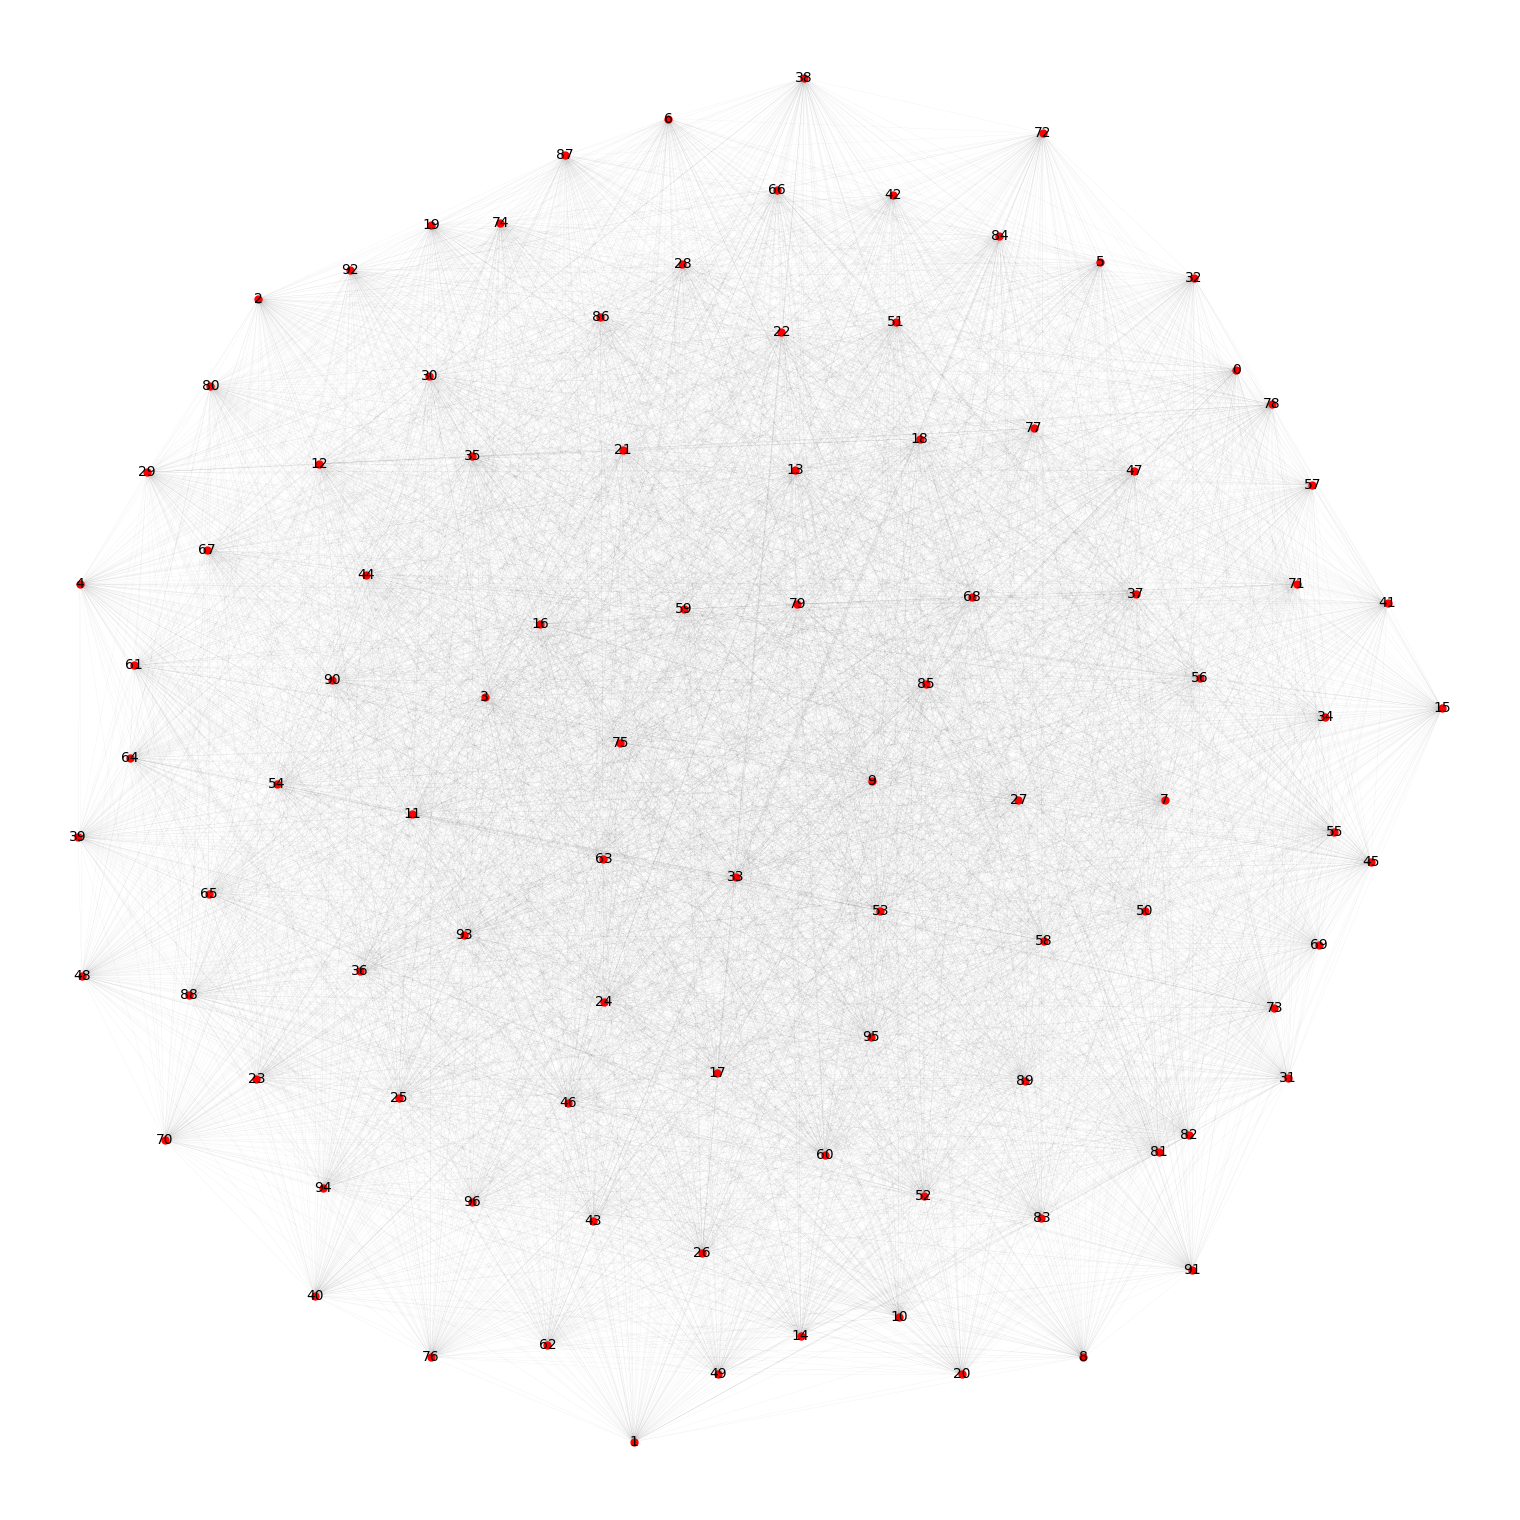

In [8]:
plt.figure(figsize = (15, 15), dpi = 100)
nx.draw(G, nx.spring_layout(G), node_color = 'red', alpha = 1, with_labels = True, node_size = 25, font_size = 10, font_weight = 'regular', width = 0.015)
plt.show()

## Initial analysis

### Network summary

Before we move on the task of finding influencers, we can do some preliminary analysis to get some interesting insights on the dataset. The `info()` method can be used to get some basic statistics about the dataset.

In [9]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 4750
Average degree:  97.9381


We can see that there are 4750 edges between the 97 nodes in the graph G. 
The average degree is simply the average number of edges per node in the graph. 
Average Degree = Total Edges / Total Nodes.

For the given graph, the average degree is 97.94, which is very close to the total number of nodes in the network. 

### Network density

We can now calculate the network density using the `density()` method on the graph. The network density is the ratio of actual edges in the network to all possible edges in the network. Network density gives you a quick sense of how closely knit your network is. The density can range from 0 (graph without edges) to 1 (complete graph - every node is connected to every other node.)

In [10]:
density = nx.density(G)
print("Network density:", density)

Network density: 1.020189003436426


The density is very high for the graph - 0.99! This reaffirms the above observation and proves that *almost* all users are connected to every other user.

### Network radius and diameter

The diameter of graph is the maximum distance between the pair of vertices. 
A radius of the graph exists only if it has the diameter. The minimum among all the maximum distances between a vertex to all other vertices is considered as the radius of the Graph G.

In [11]:
diameter = nx.diameter(G)
print("Network diameter:", diameter)
radius = nx.radius(G)
print("Network radius:", radius)

Network diameter: 2
Network radius: 1


We observe that the diameter is 2, hence the maximum distance between any 2 users in the graph is 2. The minimum among all these distance (radius), is 1. 

### Network eccentricity, center, periphery

A metric known as eccentricity is measured as the longest shortest path between this node and all other nodes of the network. We can find the center of the network, which is the set of nodes with eccentricity equal to radius. The periphery of the network consists of the set of nodes where the eccentricity is equal to the diameter.

In [12]:
center = nx.center(G)
print("Network center:", center)
periphery = nx.periphery(G)
print("Network periphery:", periphery)

Network center: [0, 2, 1, 5, 4, 6, 8, 9, 10, 3, 11, 12, 13, 19, 14, 17, 16, 15, 18, 33, 27, 20, 30, 26, 31, 32, 34, 35, 22, 23, 24, 29, 21, 25, 28, 36, 38, 37, 40, 42, 43, 45, 41, 44, 46, 39, 48, 47, 74, 81, 52, 67, 76, 66, 82, 93, 54, 56, 83, 69, 65, 79, 53, 60, 55, 61, 63, 90, 59, 77, 89, 91, 85, 62, 78, 88, 57, 49, 50, 51, 72, 92, 86, 58, 73, 75, 71, 68, 64, 70, 87, 80, 84, 94, 95]
Network periphery: [7, 96]


We can also find the eccentricity of any user in the network. For example, user 4 has an eccentricity of 1.

In [13]:
print(nx.eccentricity(G, 4))

1


We can confirm this by printing out the shortest path between this node and say, node 10 of the network. The shortest path length is 1.

In [14]:
path = nx.shortest_path(G, source = 4, target = 10)
print("Shortest path 4 and 10:", path)
print("Length of that path:", len (path) - 1)

Shortest path 4 and 10: [4, 10]
Length of that path: 1


A BFS tree can also be constructed from of a breadth-first-search starting at source node 4.

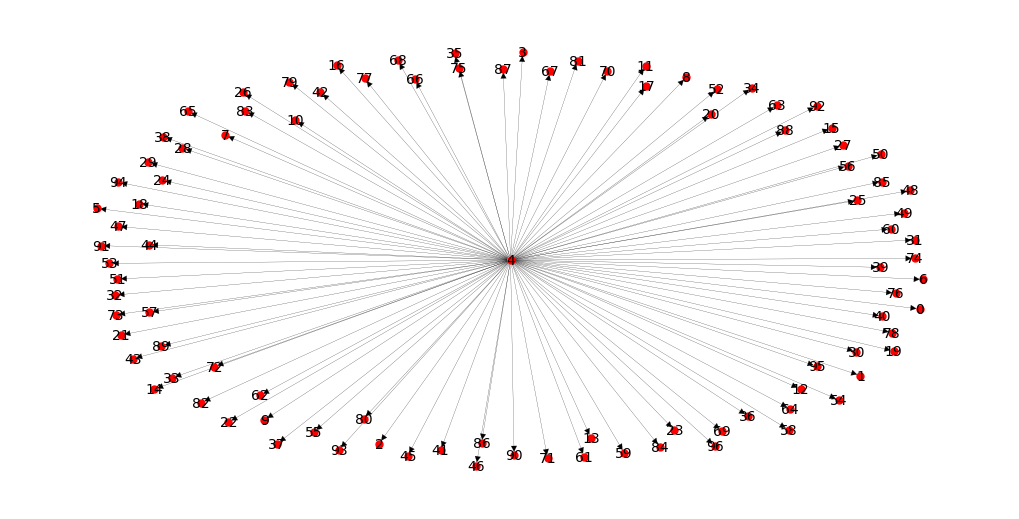

In [15]:
T = nx.bfs_tree(G, 4)
plt.figure(figsize = (10, 5), dpi = 100)
nx.draw(T, node_color = 'red', alpha = 1, with_labels = True, node_size = 25, font_size = 10, font_weight = 'regular', width = 0.15)

### Network connectivity and transitivity

A graph is said to be connected if there is a path between every pair of users, we can find if the network is connected using the `is_connected()` method on the graph.

In [16]:
print(nx.is_connected(G))

True


The value returned is true, which means that we can reach any node in the graph from any other node. Cool!

Triadic closure supposes that if two people know the same person, they are likely to know each other. If User 1 knows both User 2 and User 3, then User 2 and User 3 may very well know each other, completing a triangle in the visualization of three edges connecting User 1, User 2, and User 3. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.

We can calculate transitivity, the ratio of all triangles over all possible triangles. A possible triangle exists when one person (User 1) knows two people (User 2 and User 3). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections.

In [17]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.9997851310700473


## Determining influencers

Now, we can analyse which nodes are the influencers, or the most important nodes in the network. Identifying influencers is an important step as it identifies individuals who are popular, or have the largest impact on the network and on the transfer of information. There are various centrality measures that can be used to determine what makes an influencer important - degree, betweenness centrality, eigenvector centrality and closeness centrality.

### Degree Centrality

The most popular and well liked are the users having more friends. Hence, degree centrality can be calculated by measuring the number of edges for a user in the network. More popular users are influential in the sense that their nodes have a larger number of connections. We create the `degree_dict` dictionary to find the degree of each node in the network and then sort them by degree in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest degree.

In [18]:
degree_dict = dict(G.degree(G.nodes()))
degree_dict = {k: v for k, v in sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(degree_dict.keys())[:3]:
    print("User", k, "- Degree:", degree_dict[k])

Top 3 influencers:
User 0 - Degree: 98
User 2 - Degree: 98
User 1 - Degree: 98


**Users 4, 6, 8 are the top 3 influencers in the network when we consider degree as the centrality measure.**

### Betweenness Centrality

Betweenness centrality is a measure to find influencers by detecting which individuals influence the transfer of information. If these individuals do not exist in the network, then the information can not flow on both sides of the network. It is calculated by finding the number of shortest paths in a graph that pass through a node, divided by the number of shortest paths that exist between every pair of nodes in a graph. Influencers determined using high betweenness centrality are considered important since they stand between groups, giving the network connectivity. We create the `betweenness_dict` dictionary to find the betweenness centrality of each node in the network and then sort them by centrality in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest betweenness centrality.

In [19]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_dict = {k: v for k, v in sorted(betweenness_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(betweenness_dict.keys())[:3]:
    print("User", k, "- Betweenness Centrality:", betweenness_dict[k])

Top 3 influencers:
User 0 - Betweenness Centrality: 2.308402585410896e-06
User 2 - Betweenness Centrality: 2.308402585410896e-06
User 1 - Betweenness Centrality: 2.308402585410896e-06


Once again, we observe that **users 4, 6, 8 are the top 3 influencers in the network when we consider betweenness centrality as a metric.** These users have a strategic control and influence on others. An individual at such a strategic position can influence the whole group, by either withholding or coloring the information in transmission.

### Eigenvector Centrality

Eigenvector centrality is used when we consider a node as important if it is connected to other important nodes (similar to PageRank.) We create the `eigenvector_dict` dictionary to find the Eigenvector centrality of each node in the network and then sort them by centrality in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest Eigenvector centrality.

In [20]:
eigenvector_dict = nx.eigenvector_centrality(G)
eigenvector_dict = {k: v for k, v in sorted(eigenvector_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(eigenvector_dict.keys())[:3]:
    print("User", k, "- Eigenvector Centrality:", eigenvector_dict[k])

Top 3 influencers:
User 0 - Eigenvector Centrality: 0.10157684308624847
User 2 - Eigenvector Centrality: 0.10157684308624847
User 1 - Eigenvector Centrality: 0.10157684308624847


We observe that **users 4, 6, 8 are the top 3 influencers in the network when we consider Eigenvector centrality as a metric.**

### Closeness Centrality

Closeness centrality of a node is a measure of centrality in a network, calculated as the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes.
We create the `closeness_dict` dictionary to find the closeness centrality of each node in the network and then sort them by centrality in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest closeness centrality.

In [21]:
closeness_dict = nx.closeness_centrality(G)
closeness_dict = {k: v for k, v in sorted(closeness_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(closeness_dict.keys())[:3]:
    print("User", k, "- Closeness:", closeness_dict[k])

Top 3 influencers:
User 0 - Closeness: 1.0
User 2 - Closeness: 1.0
User 1 - Closeness: 1.0


Once again, we observe that **users 4, 6, 8 are the top 3 influencers in the network when we consider closeness centrality as a metric.**

## Additional: Cliques and communities

### Cliques

A clique is defined as a maximal complete subgraph of a given graph: a group of people where everybody is connected directly to everyone else. Since a clique is maximal, it means that no other nodes can be added to the clique without making it less connected. We can analyse if our network contains such cliques where every user is connected to every other user by using the `find_cliques()` method.

In [22]:
# Find the length of each clique present in the network
cliques = sorted([len(cl) for cl in nx.find_cliques(G)], reverse=True)
print("Total number of cliques in network:", len(cliques))
print("Sizes of all cliques:", cliques)

Total number of cliques in network: 2
Sizes of all cliques: [96, 96]


It is interesting to note that there are 22 cliques in the network - the largest of which being of size 91. In those cliques, every user is connected to every other user! The smallest clique is of size 32.

### Communities

We can also find communities in the graph using the Clauset-Newman-Moore greedy modularity maximization. Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.

In [23]:
communities = greedy_modularity_communities(G)
community_sizes = sorted([len(cl) for cl in greedy_modularity_communities(G)], reverse=True)
print("Total number of communities in network:", len(communities))
print("Sizes of all cliques:", community_sizes)

Total number of communities in network: 93
Sizes of all cliques: [5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


It is observed that the network has 26 communities, and even the largest of them only contains 38 nodes. We can print out the users in the largest community. It is possible that these users may belong to or frequently browse the same subreddit.

In [24]:
print("Users in largest community:", list(communities[0]))

Users in largest community: [0, 1, 2, 96, 95]


# Analysing only discussion classified threads

## Creating and visualising the graph

<a id='discussion-only'></a>
As the assignment includes finding the influencers in the discussion based threads, we can consider building a graph only from those threads that are classified as 1. The network is a symmetric network - if User A is related to User B, User B is also related to User A. 

We will be using the `Graph()` method to create a new network and `add_edge()` to add an edge between two nodes. The condition for adding edges from a thread is that it should be a discussion.

A similar analysis performed using the entire dataset can be found above, [here](#whole-dataset)

In [56]:
# Initialise an empty graph
M = nx.MultiGraph()

In [57]:
# Loop through all threads in the reddit_edges object
for k, v in reddit_edges.items():
    thread_number = k
    # Lookup the thread in the reddit_target dataframe to see if it is discussion
    if reddit_target.iloc[int(k)].target == 1:
        replies = v
        # If the thread is a discussion, loop through all the replies (edges) in it
        for reply in replies:
            # Add each edge to the graph
            M.add_edge(reply[0], reply[1])

In [58]:
# create weighted graph from M
G = nx.Graph()
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)

print(G.edges(data=True))
# [(1, 2, {'weight': 26}), (2, 3, {'weight': 42})]

[(0, 3, {'weight': 14275.0}), (0, 6, {'weight': 14324.0}), (0, 1, {'weight': 14304.0}), (0, 2, {'weight': 14130.0}), (0, 4, {'weight': 14211.0}), (0, 5, {'weight': 14084.0}), (0, 7, {'weight': 14241.0}), (0, 8, {'weight': 14344.0}), (0, 9, {'weight': 14382.0}), (0, 10, {'weight': 14239.0}), (0, 15, {'weight': 5208.0}), (0, 11, {'weight': 12037.0}), (0, 13, {'weight': 7855.0}), (0, 14, {'weight': 6311.0}), (0, 39, {'weight': 274.0}), (0, 21, {'weight': 1880.0}), (0, 17, {'weight': 3557.0}), (0, 12, {'weight': 9857.0}), (0, 20, {'weight': 2136.0}), (0, 16, {'weight': 4277.0}), (0, 19, {'weight': 2523.0}), (0, 0, {'weight': 963.0}), (0, 63, {'weight': 58.0}), (0, 25, {'weight': 1082.0}), (0, 33, {'weight': 476.0}), (0, 24, {'weight': 1235.0}), (0, 27, {'weight': 850.0}), (0, 44, {'weight': 204.0}), (0, 38, {'weight': 274.0}), (0, 57, {'weight': 89.0}), (0, 18, {'weight': 2993.0}), (0, 28, {'weight': 788.0}), (0, 29, {'weight': 661.0}), (0, 30, {'weight': 615.0}), (0, 22, {'weight': 1645.0

We can now view all the nodes in this graph to see all the users who are a part of it.

In [59]:
nodes_list = G.nodes
print("Users in the graph:", nodes_list)
print("Total number of users in the graph: ", len(nodes_list))

Users in the graph: [0, 3, 6, 1, 2, 4, 5, 7, 8, 9, 10, 15, 11, 13, 14, 39, 21, 17, 12, 20, 16, 19, 63, 25, 33, 24, 27, 44, 38, 57, 18, 28, 29, 30, 22, 23, 26, 31, 37, 72, 58, 54, 49, 32, 34, 35, 36, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 55, 53, 56, 59, 61, 65, 66, 67, 68, 69, 70, 71, 74, 76, 79, 80, 85, 60, 62, 87, 77, 91, 92, 73, 64, 75, 94, 81, 84, 78, 88, 83, 89, 82, 86, 90, 96, 95, 93]
Total number of users in the graph:  97


We can use the `draw()` method to easily visualise the graph and all the nodes in it. Due to the size of the dataset, the graph is very large. 

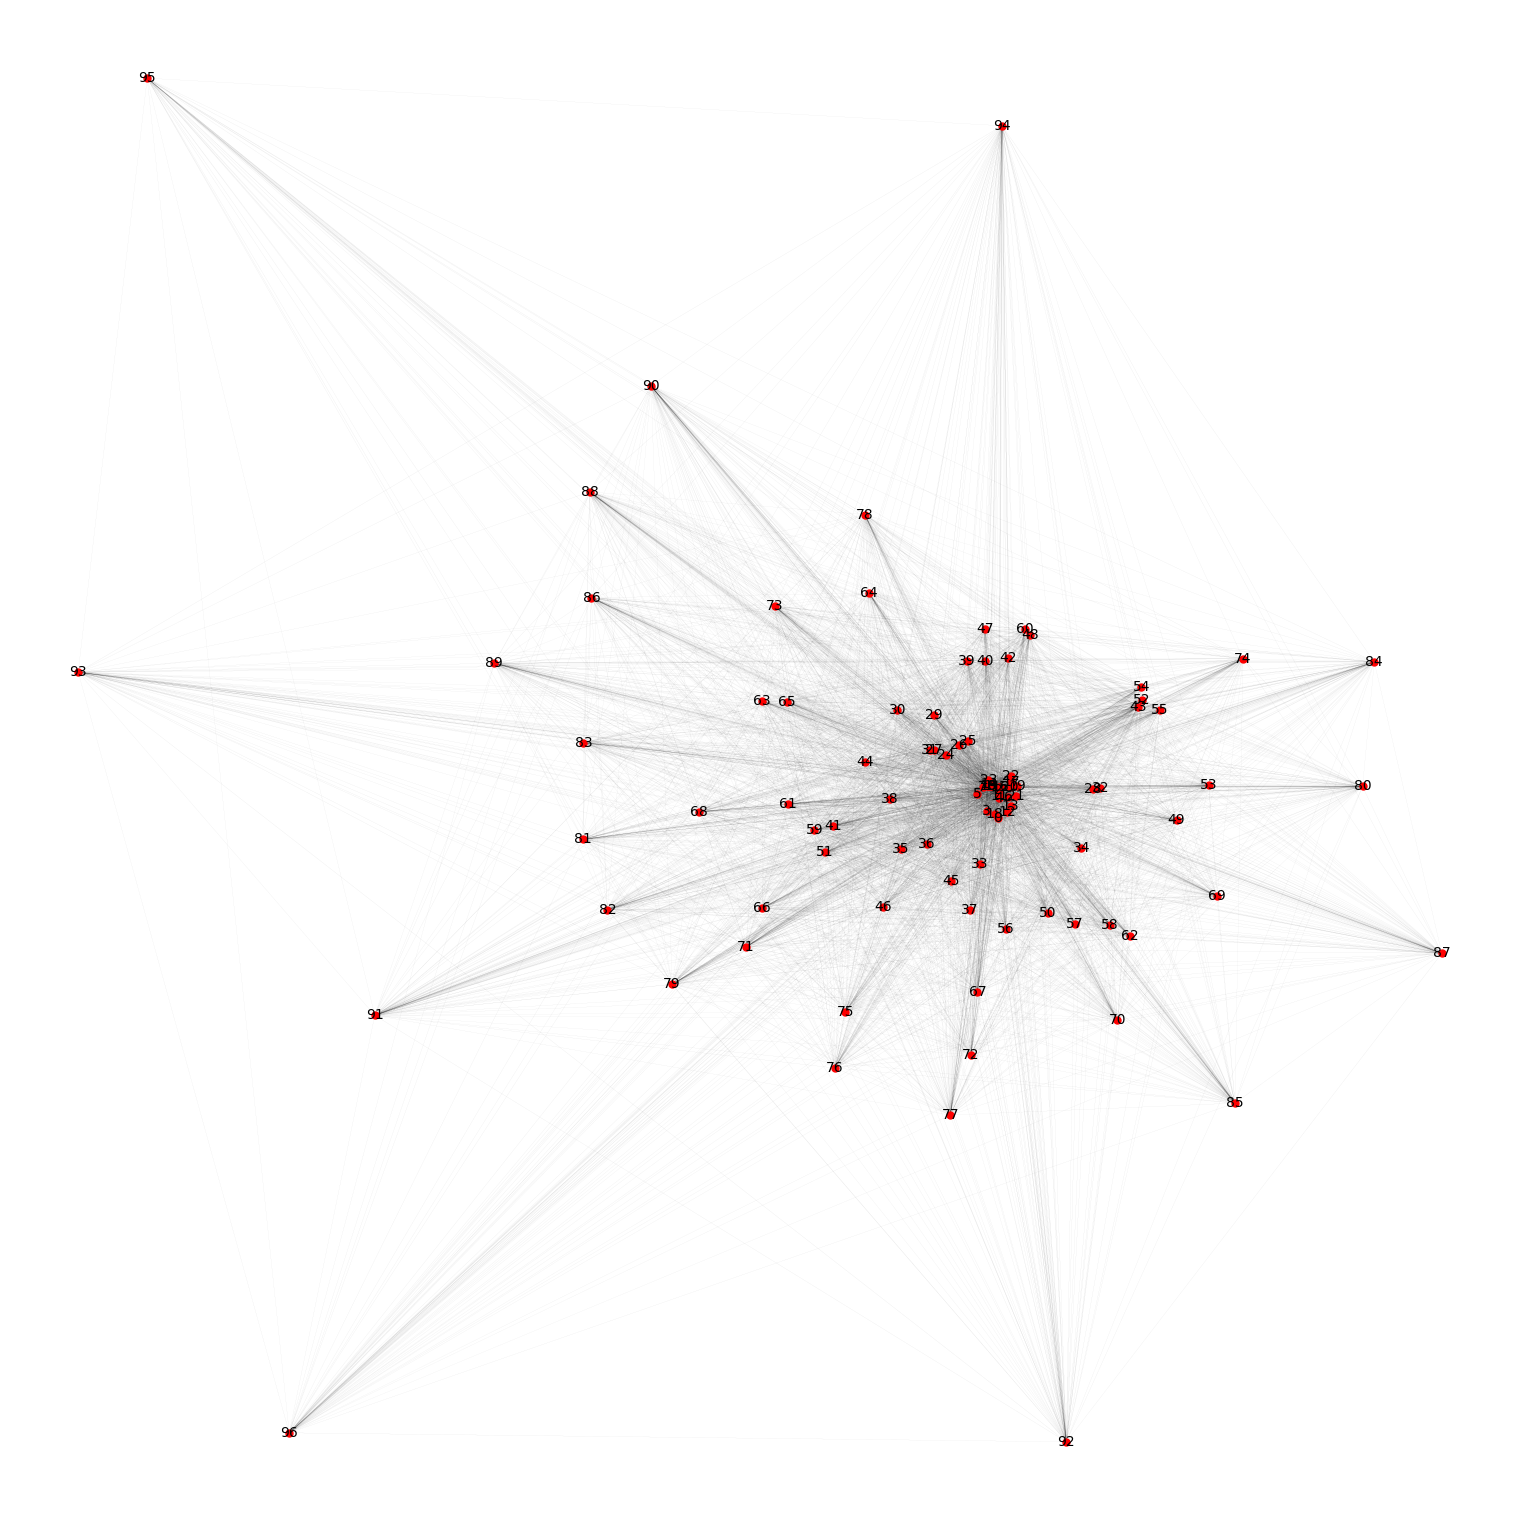

In [60]:
plt.figure(figsize = (15, 15), dpi = 100)
nx.draw(G, nx.spring_layout(G), node_color = 'red', alpha = 1, with_labels = True, node_size = 25, font_size = 10, font_weight = 'regular', width = 0.015)
plt.show()

## Initial analysis

### Network summary

Before we move on the task of finding influencers, we can do some preliminary analysis to get some interesting insights on the dataset. The `info()` method can be used to get some basic statistics about the dataset.

In [61]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 4631
Average degree:  95.4845


We can see that there are 4631 edges between the 97 nodes in the graph G. 
The average degree is simply the average number of edges per node in the graph. 
Average Degree = Total Edges / Total Nodes.

For the given graph, the average degree is 95.48, which is very close to the total number of nodes in the network. Hence, this implies that there are almost 95 replies linking every user to every other user on an average!

### Network density

We can now calculate the network density using the `density()` method on the graph. The network density is the ratio of actual edges in the network to all possible edges in the network. Network density gives you a quick sense of how closely knit your network is. The density can range from 0 (graph without edges) to 1 (complete graph - every node is connected to every other node.)

In [62]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.9946305841924399


The density is very high for the graph - 0.99! This reaffirms the above observation and proves that *almost* all users are connected to every other user.

### Network radius and diameter

The diameter of graph is the maximum distance between the pair of vertices. 
A radius of the graph exists only if it has the diameter. The minimum among all the maximum distances between a vertex to all other vertices is considered as the radius of the Graph G.

In [63]:
diameter = nx.diameter(G)
print("Network diameter:", diameter)
radius = nx.radius(G)
print("Network radius:", radius)

Network diameter: 2
Network radius: 1


We observe that the diameter is 2, hence the maximum distance between any 2 users in the graph is 2. The minimum among all these distance (radius), is 1. 

### Network eccentricity, center, periphery

A metric known as eccentricity is measured as the longest shortest path between this node and all other nodes of the network. We can find the center of the network, which is the set of nodes with eccentricity equal to radius. The periphery of the network consists of the set of nodes where the eccentricity is equal to the diameter.

In [64]:
center = nx.center(G)
print("Network center:", center)
periphery = nx.periphery(G)
print("Network periphery:", periphery)

Network center: [6, 4, 8, 21, 17, 12, 63, 25, 33, 27, 23, 26, 41, 42, 48, 59, 61, 67, 79, 60, 91, 73, 75, 81, 84, 78, 89]
Network periphery: [0, 3, 1, 2, 5, 7, 9, 10, 15, 11, 13, 14, 39, 20, 16, 19, 24, 44, 38, 57, 18, 28, 29, 30, 22, 31, 37, 72, 58, 54, 49, 32, 34, 35, 36, 40, 43, 45, 46, 47, 50, 51, 52, 55, 53, 56, 65, 66, 68, 69, 70, 71, 74, 76, 80, 85, 62, 87, 77, 92, 64, 94, 88, 83, 82, 86, 90, 96, 95, 93]


We can also find the eccentricity of any user in the network. For example, user 4 has an eccentricity of 1.

In [65]:
print(nx.eccentricity(G, 4))

1


We can confirm this by printing out the shortest path between this node and say, node 10 of the network. The shortest path length is 1.

In [66]:
path = nx.shortest_path(G, source = 4, target = 10)
print("Shortest path 4 and 10:", path)
print("Length of that path:", len (path) - 1)

Shortest path 4 and 10: [4, 10]
Length of that path: 1


A BFS tree can also be constructed from of a breadth-first-search starting at source node 4.

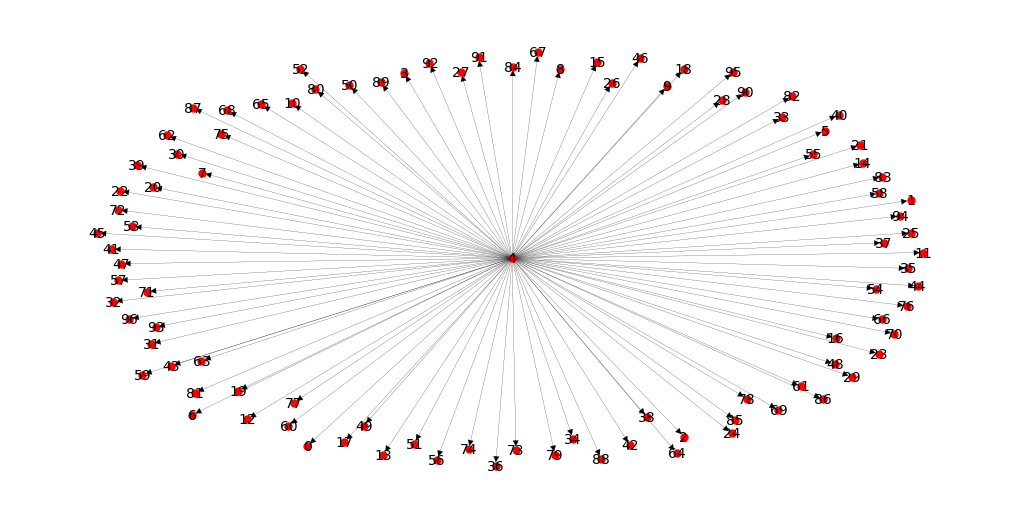

In [67]:
T = nx.bfs_tree(G, 4)
plt.figure(figsize = (10, 5), dpi = 100)
nx.draw(T, node_color = 'red', alpha = 1, with_labels = True, node_size = 25, font_size = 10, font_weight = 'regular', width = 0.15)

### Network connectivity and transitivity

A graph is said to be connected if there is a path between every pair of users, we can find if the network is connected using the `is_connected()` method on the graph.

In [68]:
print(nx.is_connected(G))

True


The value returned is true, which means that we can reach any node in the graph from any other node. Cool!

Triadic closure supposes that if two people know the same person, they are likely to know each other. If User 1 knows both User 2 and User 3, then User 2 and User 3 may very well know each other, completing a triangle in the visualization of three edges connecting User 1, User 2, and User 3. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.

We can calculate transitivity, the ratio of all triangles over all possible triangles. A possible triangle exists when one person (User 1) knows two people (User 2 and User 3). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections.

In [69]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.9834418274351995


## Determining influencers

Now, we can analyse which nodes are the influencers, or the most important nodes in the network. Identifying influencers is an important step as it identifies individuals who are popular, or have the largest impact on the network and on the transfer of information. There are various centrality measures that can be used to determine what makes an influencer important - degree, betweenness centrality, eigenvector centrality and closeness centrality.

In [95]:
G_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, G_distance_dict, 'distance')

### Degree Centrality

The most popular and well liked are the users having more friends. Hence, degree centrality can be calculated by measuring the number of edges for a user in the network. More popular users are influential in the sense that their nodes have a larger number of connections. We create the `degree_dict` dictionary to find the degree of each node in the network and then sort them by degree in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest degree.

In [84]:
# degree_dict = dict(G.degree(G.nodes()))
degree_dict = dict(G.degree(weight='weight'))
degree_dict = {k: v for k, v in sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(degree_dict.keys())[:3]:
    print("User", k, "- Degree:", degree_dict[k])

Top 3 influencers:
User 0 - Degree: 219495.0
User 6 - Degree: 209178.0
User 8 - Degree: 208632.0


**Users 4, 6, 8 are the top 3 influencers in the network when we consider degree as the centrality measure.**

### Betweenness Centrality

Betweenness centrality is a measure to find influencers by detecting which individuals influence the transfer of information. If these individuals do not exist in the network, then the information can not flow on both sides of the network. It is calculated by finding the number of shortest paths in a graph that pass through a node, divided by the number of shortest paths that exist between every pair of nodes in a graph. Influencers determined using high betweenness centrality are considered important since they stand between groups, giving the network connectivity. We create the `betweenness_dict` dictionary to find the betweenness centrality of each node in the network and then sort them by centrality in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest betweenness centrality.

In [96]:
betweenness_dict = nx.betweenness_centrality(G, weight='distance')
betweenness_dict = {k: v for k, v in sorted(betweenness_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(betweenness_dict.keys())[:3]:
    print("User", k, "- Betweenness Centrality:", betweenness_dict[k])

Top 3 influencers:
User 0 - Betweenness Centrality: 0.16853070175438598
User 4 - Betweenness Centrality: 0.09627192982456141
User 1 - Betweenness Centrality: 0.075


Once again, we observe that **users 4, 6, 8 are the top 3 influencers in the network when we consider betweenness centrality as a metric.** These users have a strategic control and influence on others. An individual at such a strategic position can influence the whole group, by either withholding or coloring the information in transmission.

### Eigenvector Centrality

Eigenvector centrality is used when we consider a node as important if it is connected to other important nodes (similar to PageRank.) We create the `eigenvector_dict` dictionary to find the Eigenvector centrality of each node in the network and then sort them by centrality in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest Eigenvector centrality.

In [89]:
eigenvector_dict = nx.eigenvector_centrality(G, weight='weight')
eigenvector_dict = {k: v for k, v in sorted(eigenvector_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(eigenvector_dict.keys())[:3]:
    print("User", k, "- Eigenvector Centrality:", eigenvector_dict[k])

Top 3 influencers:
User 0 - Eigenvector Centrality: 0.28278686522899277
User 6 - Eigenvector Centrality: 0.27097529001775583
User 8 - Eigenvector Centrality: 0.27056751547928215


We observe that **users 4, 6, 8 are the top 3 influencers in the network when we consider Eigenvector centrality as a metric.**

### Closeness Centrality

Closeness centrality of a node is a measure of centrality in a network, calculated as the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes.
We create the `closeness_dict` dictionary to find the closeness centrality of each node in the network and then sort them by centrality in a descending order. For the scope of this assignment, we find the influencers by considering the top 3 nodes with the highest closeness centrality.

In [97]:
closeness_dict = nx.closeness_centrality(G, distance='distance')
closeness_dict = {k: v for k, v in sorted(closeness_dict.items(), key=lambda item: item[1], reverse=True)}
print("Top 3 influencers:")
for k in list(closeness_dict.keys())[:3]:
    print("User", k, "- Closeness:", closeness_dict[k])

Top 3 influencers:
User 0 - Closeness: 35.147881503464376
User 1 - Closeness: 35.131353361530806
User 4 - Closeness: 35.124596973970405


Once again, we observe that **users 4, 6, 8 are the top 3 influencers in the network when we consider closeness centrality as a metric.**

## Additional: Cliques and communities

### Cliques

A clique is defined as a maximal complete subgraph of a given graph: a group of people where everybody is connected directly to everyone else. Since a clique is maximal, it means that no other nodes can be added to the clique without making it less connected. We can analyse if our network contains such cliques where every user is connected to every other user by using the `find_cliques()` method.

In [75]:
# Find the length of each clique present in the network
cliques = sorted([len(cl) for cl in nx.find_cliques(G)], reverse=True)
print("Total number of cliques in network:", len(cliques))
print("Sizes of all cliques:", cliques)

Total number of cliques in network: 22
Sizes of all cliques: [91, 91, 89, 89, 81, 80, 71, 71, 70, 70, 67, 63, 63, 61, 51, 46, 43, 43, 38, 38, 35, 32]


It is interesting to note that there are 22 cliques in the network - the largest of which being of size 91. In those cliques, every user is connected to every other user! The smallest clique is of size 32.

### Communities

We can also find communities in the graph using the Clauset-Newman-Moore greedy modularity maximization. Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.

In [76]:
communities = greedy_modularity_communities(G)
community_sizes = sorted([len(cl) for cl in greedy_modularity_communities(G)], reverse=True)
print("Total number of communities in network:", len(communities))
print("Sizes of all cliques:", community_sizes)

Total number of communities in network: 1
Sizes of all cliques: [97]


It is observed that the network has 26 communities, and even the largest of them only contains 38 nodes. We can print out the users in the largest community. It is possible that these users may belong to or frequently browse the same subreddit.

In [77]:
print("Users in largest community:", list(communities[0]))

Users in largest community: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
